# Week 8 Assignment: Single-cell RNA-seq

## Zelin Wei

### 1. Read in scRNA-seq data

Use `scanpy` to read and process scRNA-seq data.

In [150]:
import scanpy as sc

In [151]:
adata = sc.read_10x_h5("neuron_10k_v3_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 11843 × 31053
    var: 'gene_ids', 'feature_types', 'genome'

### 2. Pre-processing data with `scanpy.pp`

Run a PCA analysis with original data:

... storing 'feature_types' as categorical
... storing 'genome' as categorical


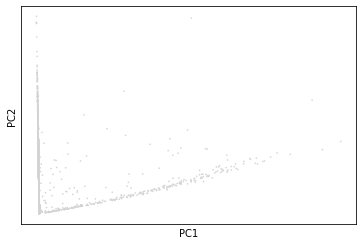

In [152]:
sc.tl.pca(adata)
sc.pl.pca(adata, save = 'BeforePP')

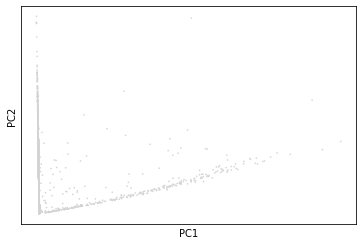

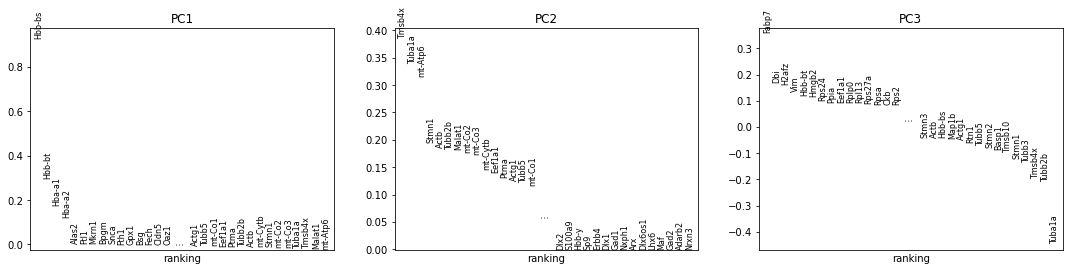

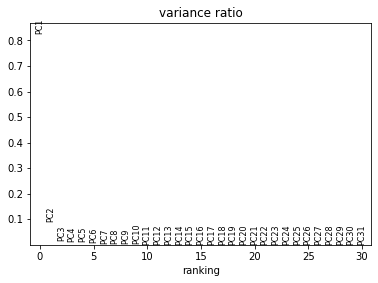

In [153]:
sc.pl.pca_overview(adata)

From the results of `pca_overview` we can see that only the first two PCs are responsible for nearly all the variance. To further pre-process the data, I use `scanpy.pp.recipe_zheng17` to select genes based on Zheng, et al, 2017.

In [154]:
sc.pp.recipe_zheng17(adata)

Run a PCA again and we can see the data are better presented and the first 15 PCs are affecting the variance now.

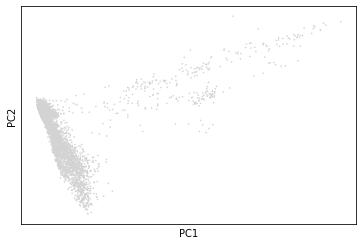

In [155]:
sc.tl.pca(adata)
sc.pl.pca(adata, save = 'AfterPP')

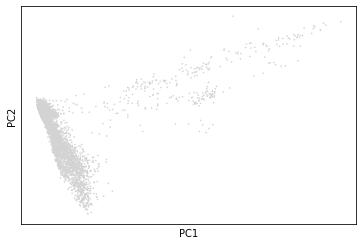

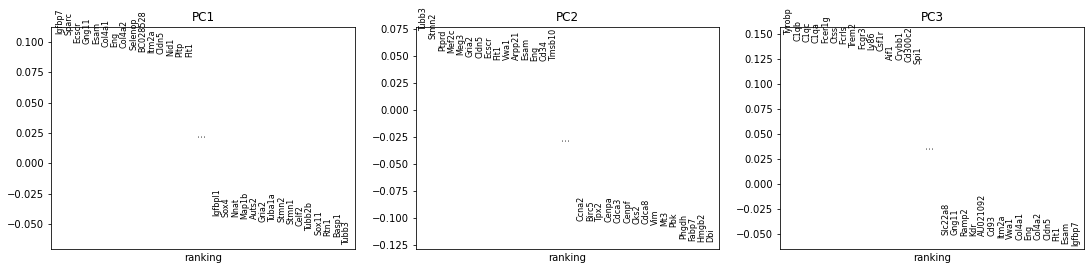

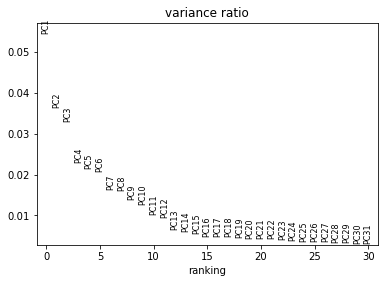

In [156]:
sc.pl.pca_overview(adata)

### 3. Clustering the cells

Then I use `leiden` to cluster neighboring cells.

In [157]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

Run a tsne plotting and U-map plotting.

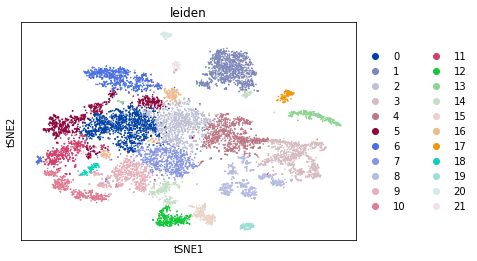

In [158]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color = 'leiden', save = 'Original')

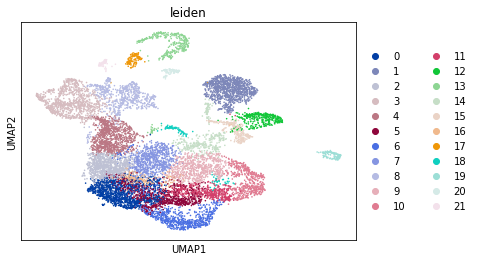

In [159]:
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'leiden', save = 'Original')

### 4. Identify distinguishing genes among clusters

I use both `t-test` and `logreg` methods to identify genes that distinguish different clusters.

/Users/zelinwei/miniconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


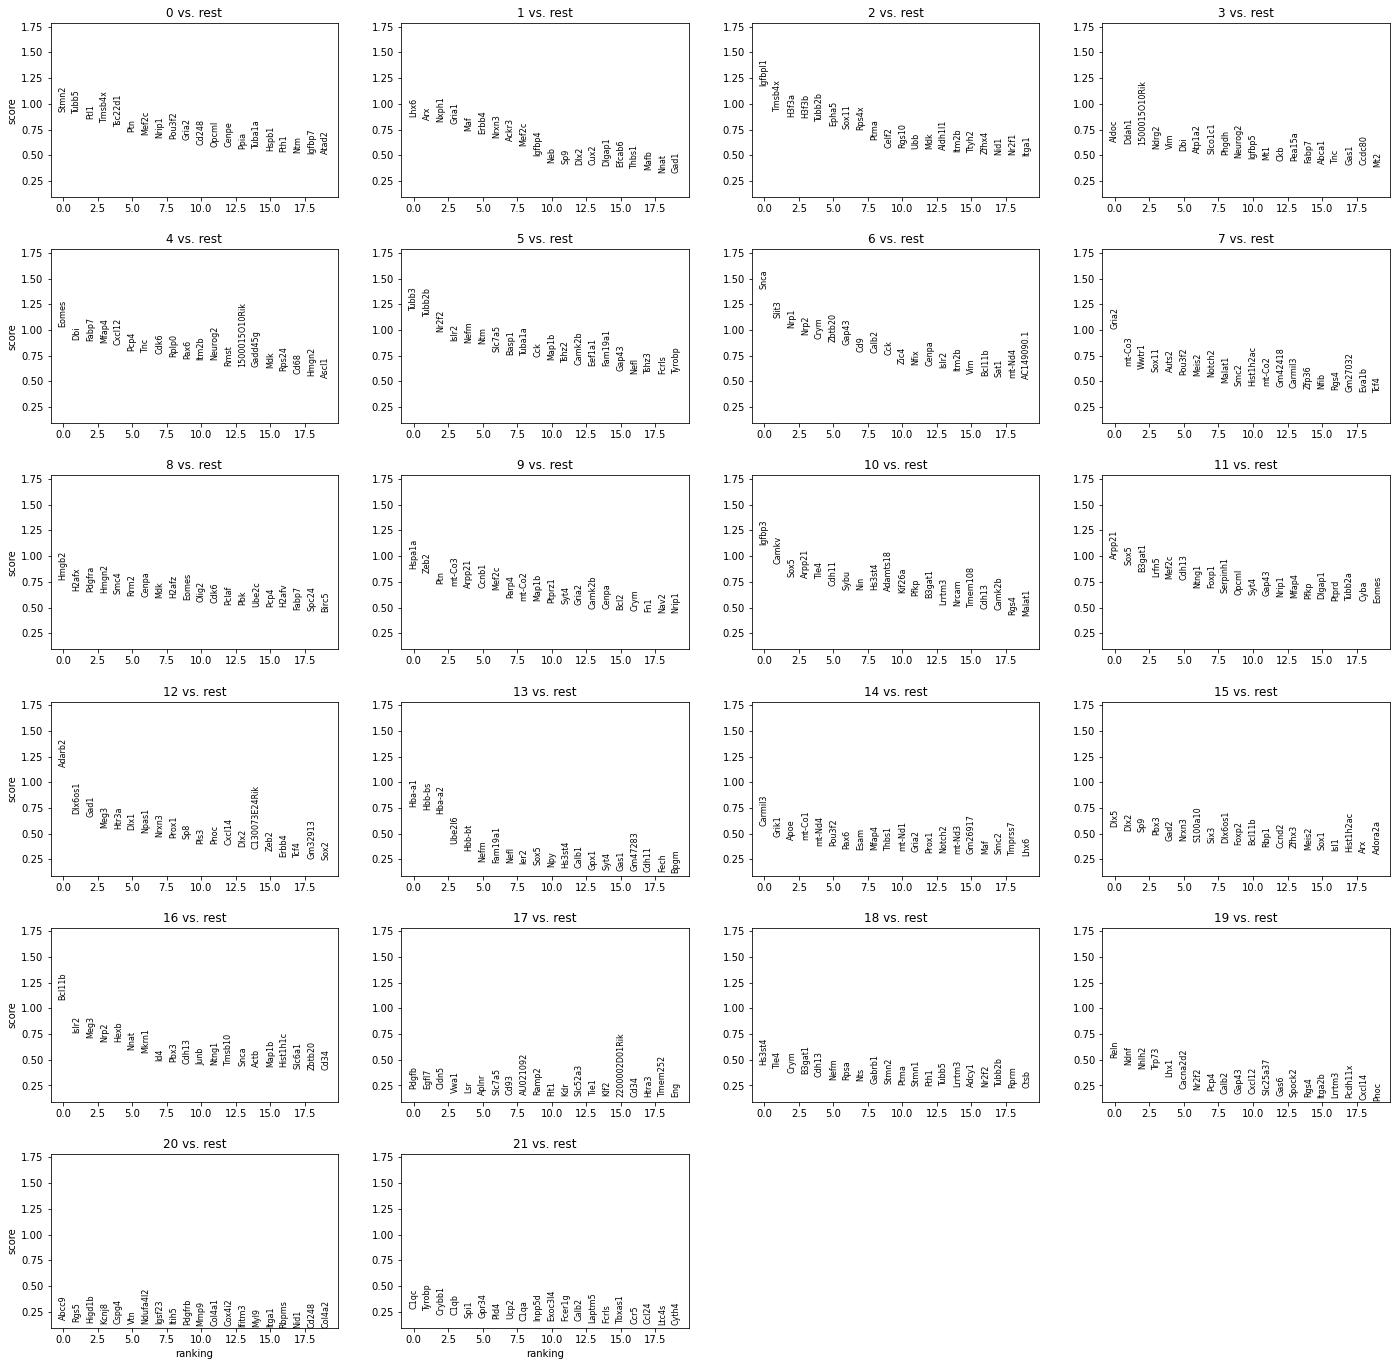

In [160]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 'logreg')
sc.pl.rank_genes_groups(adata, save = 'logistic')

/Users/zelinwei/miniconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


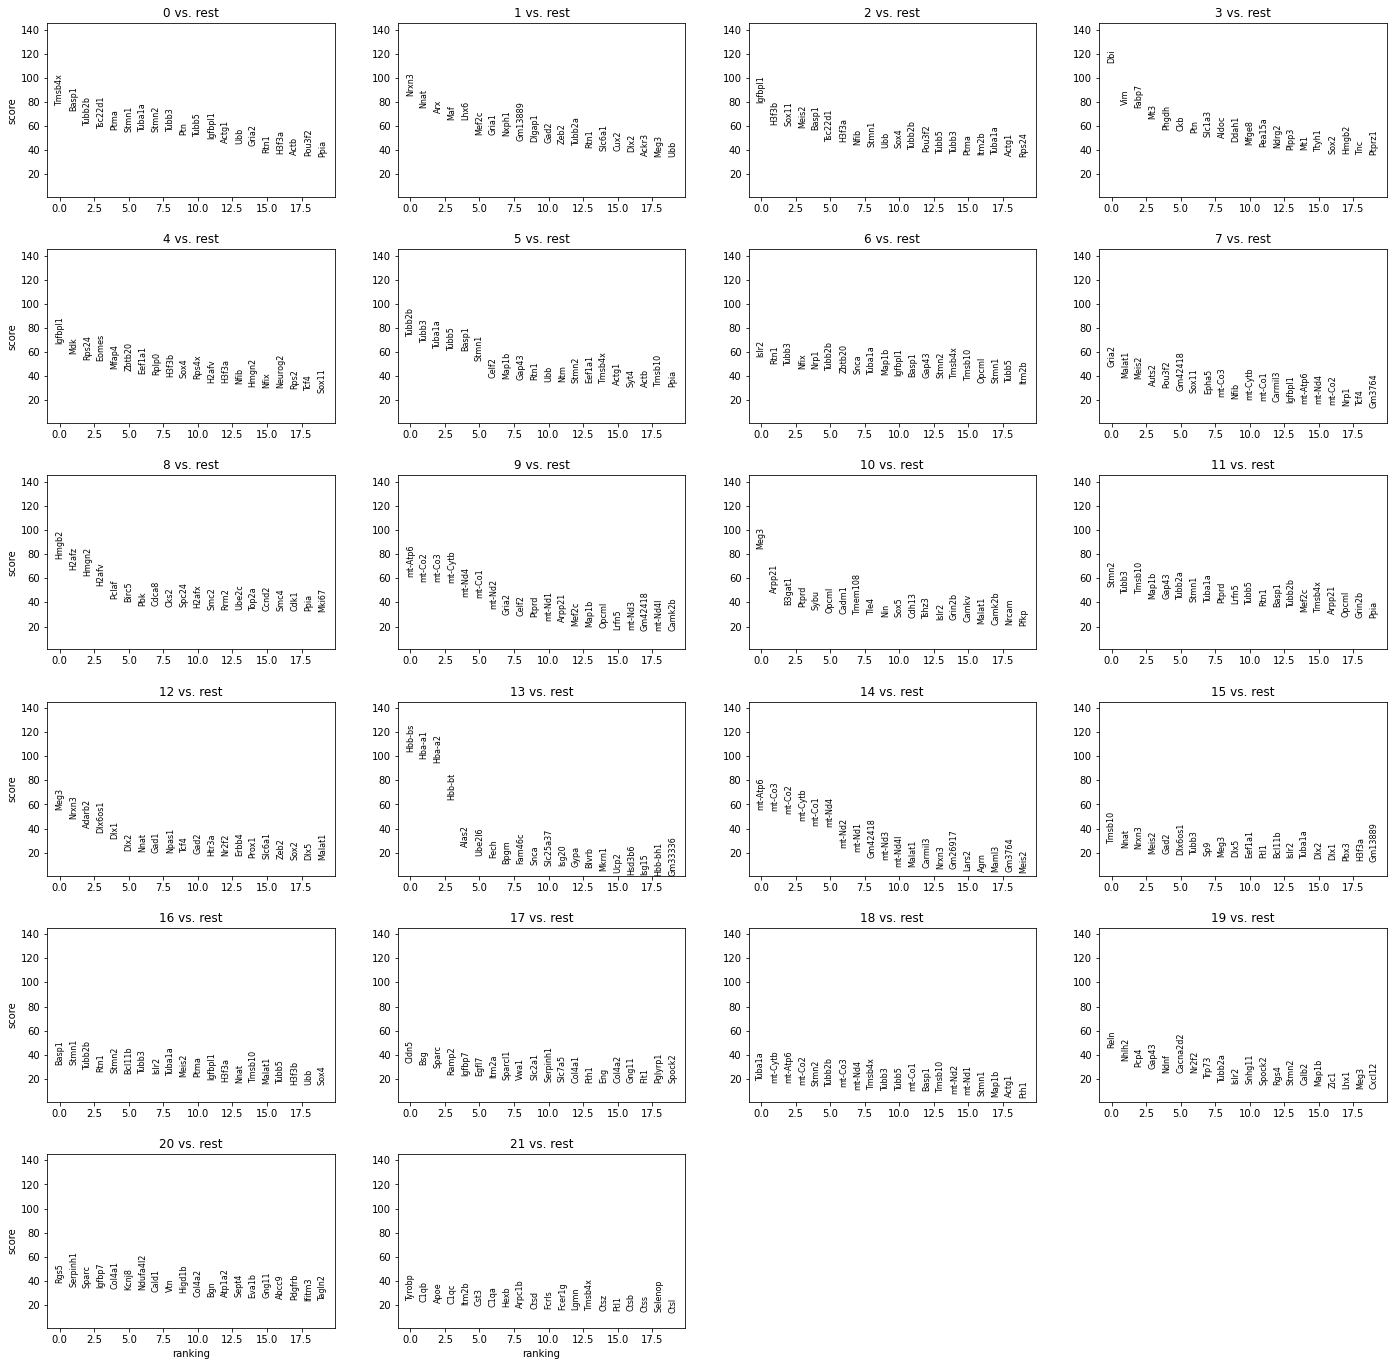

In [161]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 't-test')
sc.pl.rank_genes_groups(adata, save = 'ttest')

### 5. Identify cell types

First, use a function to retrieve gene names distinguishing each group:

In [162]:
def rankgenenames(data, group, ngene = 20):
    allgenes = data.uns['rank_genes_groups']['names']
    genenames = []
    for each in allgenes[0:ngene]:
        genenames.append(each[group])
    return genenames

Use `dotplot` to see which genes are most distinguishing among groups.

For group 1, we can see that Maf and Lhx6 are most specifically expressed. Lhx6 is required in GABAergic interneuron development in cerebral cortex, and expression data in [MGI](http://www.informatics.jax.org/gxd/marker/MGI:1306803?tab=stagegridtab#gxd=markerMgiId%3DMGI%3A1306803%26theilerStage%3D%26assayType%3D%26results%3D100%26startIndex%3D0%26sort%3D%26dir%3Dasc%26tab%3Dstagegridtab%26structureIDFilter%3DEMAPA%3A16894%26theilerStageFilter%3D26) also shows that Lhx6 is specifically expressed in cerebral cortex during E18. Therefore, group 1 likely represents Lhx6(+) GABAergic cerebral cortex interneurons.

I also notice that group 12 has a similar expressin profile as group 1 (the expression of Dlx2, for example), and it turns out that group 12 also represents a subpopulation of GABAergic neurons. More details about group 12 will be discussed later.

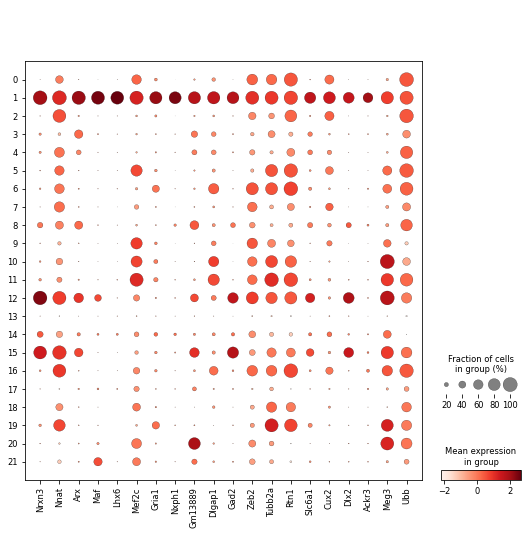

In [163]:
sc.pl.dotplot(adata, groupby = 'leiden', var_names = rankgenenames(adata, 1), save = 'G1')

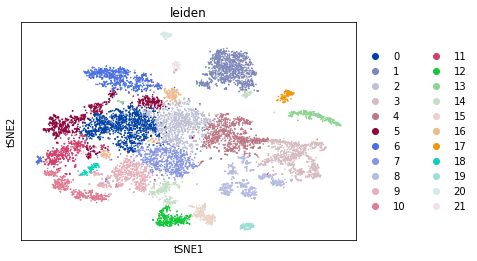

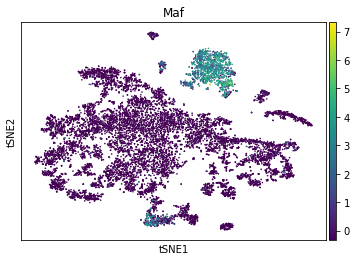

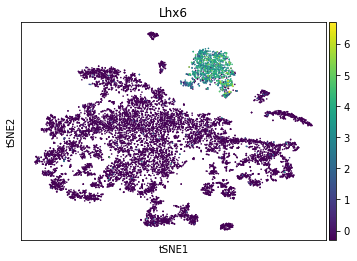

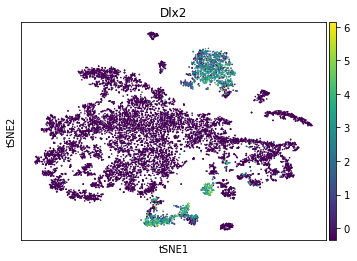

In [164]:
sc.pl.tsne(adata, color = 'leiden')
sc.pl.tsne(adata, color = 'Maf')
sc.pl.tsne(adata, color = 'Lhx6')
sc.pl.tsne(adata, color = 'Dlx2')

In group 8, we can see high expression of many genes involved in cell mitosis and cell cycle progressing, including cdk1, birc5, and smc2. Combining that they also express the neural stem cell marker Sox2, it is likely that group 8 represents proliferating neural stem cells.

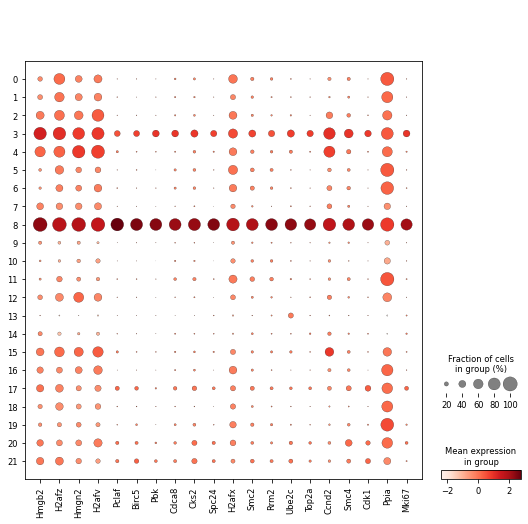

In [165]:
sc.pl.dotplot(adata, groupby = 'leiden', var_names = rankgenenames(adata, 8), save = 'G8')

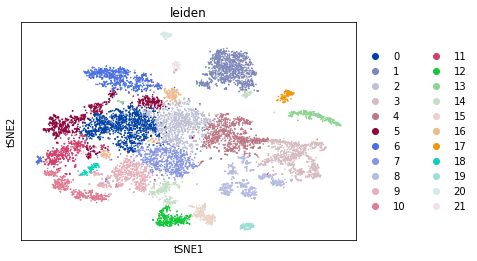

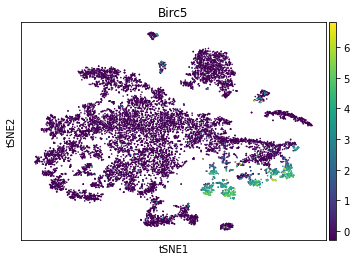

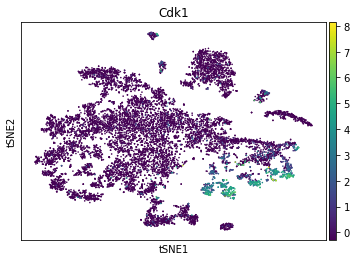

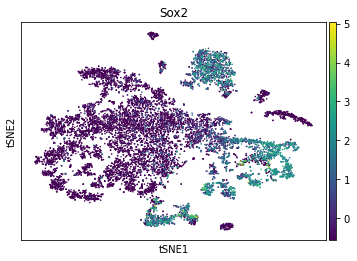

In [166]:
sc.pl.tsne(adata, color = 'leiden')
sc.pl.tsne(adata, color = 'Birc5')
sc.pl.tsne(adata, color = 'Cdk1')
sc.pl.tsne(adata, color = 'Sox2')

In group 10, we can see high expression of Sox5, a marker for [corticofugal neurons](https://www.sciencedirect.com/science/article/pii/S0896627308000263?via%3Dihub). Another important marker being expressed in Tle4, which is specific for layer VI and V neurons. Taken together, group 10 likely represents layer VI/V subcerebral neurons.

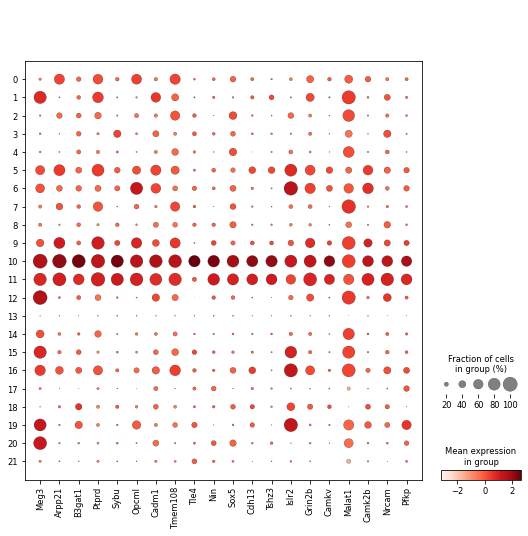

In [167]:
sc.pl.dotplot(adata, groupby = 'leiden', var_names = rankgenenames(adata, 10), save = 'G10')

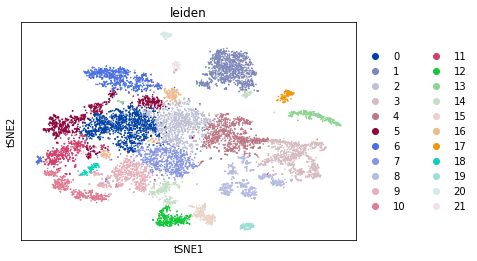

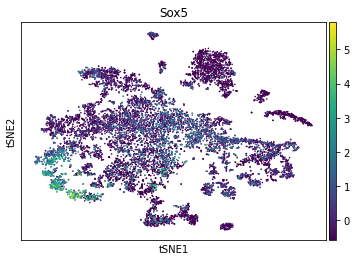

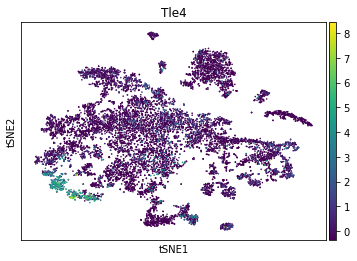

In [168]:
sc.pl.tsne(adata, color = 'leiden')
sc.pl.tsne(adata, color = 'Sox5')
sc.pl.tsne(adata, color = 'Tle4')

In group 12, we can find high expression of Dlx1/2, which regulate [GABAergic neuron development](https://www.sciencedirect.com/science/article/pii/S0306452211009560?via%3Dihub). Furthermore, Npas1 is also specifically expressed. In [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6117588/), the expression of Lhx6 and Npas1 in GABAergic neurons are discussed in details, and therefore group 12 represents the Npas1(+) GABAergic neurons while group 1 represents Npas1(+) GABAergic neurons.

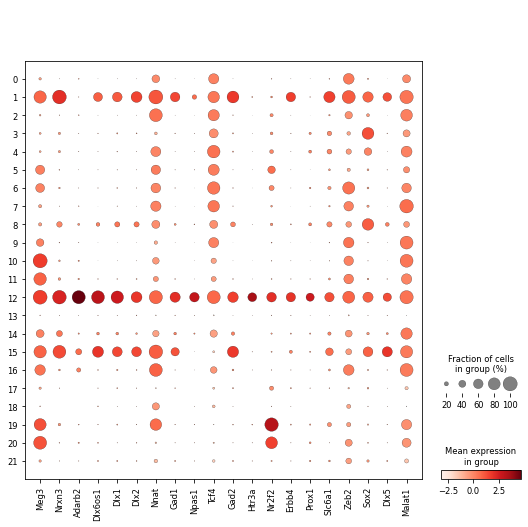

In [169]:
sc.pl.dotplot(adata, groupby = 'leiden', var_names = rankgenenames(adata, 12), save = 'G12')

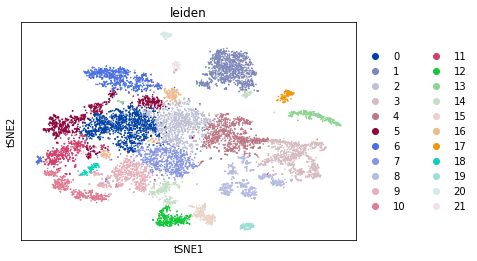

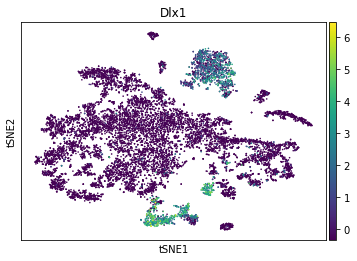

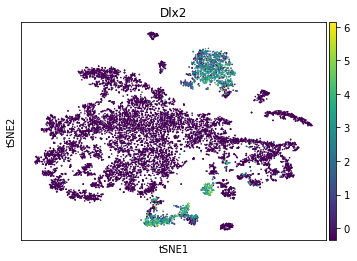

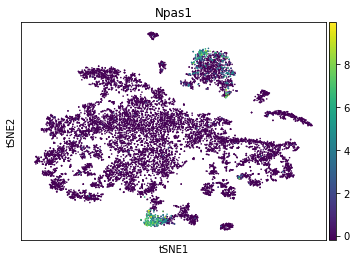

In [170]:
sc.pl.tsne(adata, color = 'leiden')
sc.pl.tsne(adata, color = 'Dlx1')
sc.pl.tsne(adata, color = 'Dlx2')
sc.pl.tsne(adata, color = 'Npas1')

Interestingly, group 13 expresses hemoglobins at a very high level, and also the erythroid-specific form of 5-aminolevulinate synthase Alas2. Therefore, group 13 very likely represents erythroids in brain blood vessels.

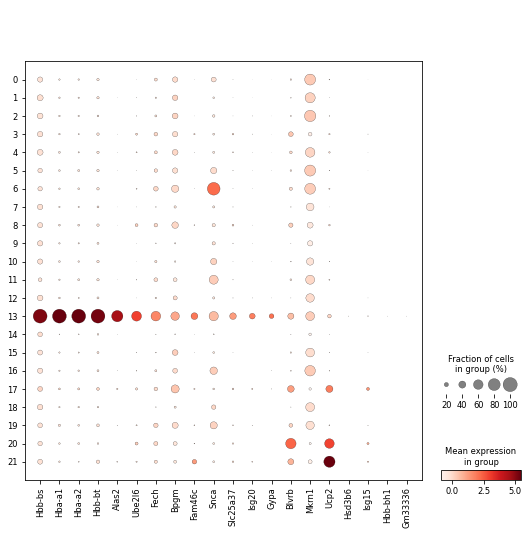

In [171]:
sc.pl.dotplot(adata, groupby = 'leiden', var_names = rankgenenames(adata, 13), save = 'G13')

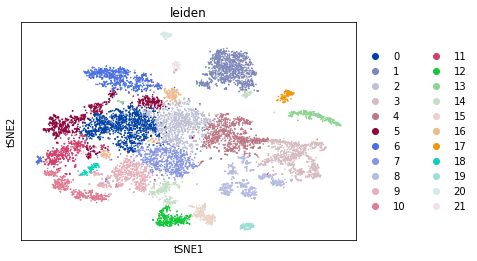

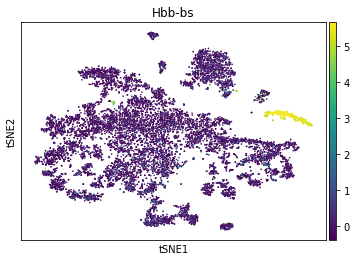

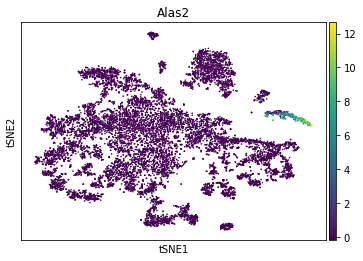

In [172]:
sc.pl.tsne(adata, color = 'leiden')
sc.pl.tsne(adata, color = 'Hbb-bs')
sc.pl.tsne(adata, color = 'Alas2')

In group 17, Cldn5 is specifically expressed. Since Claudin is required for tight junction, group 17 is likely to be brain capillary endothelial cells.

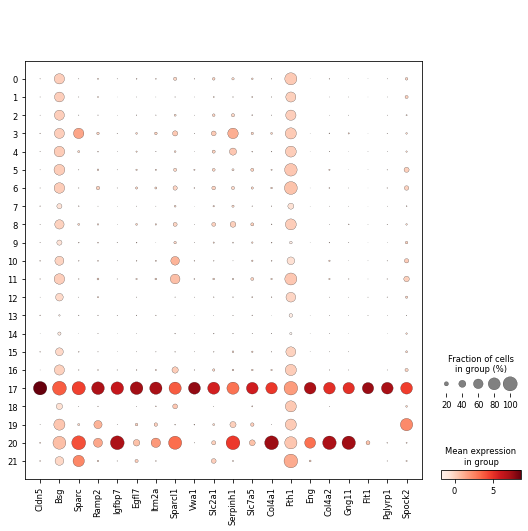

In [173]:
sc.pl.dotplot(adata, groupby = 'leiden', var_names = rankgenenames(adata, 17), save = 'G17')

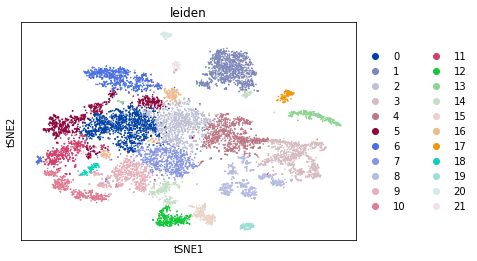

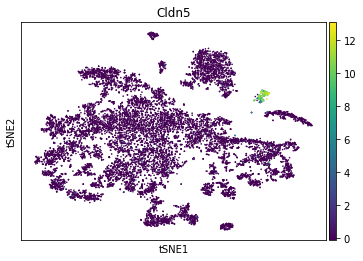

In [174]:
sc.pl.tsne(adata, color = 'leiden')
sc.pl.tsne(adata, color = 'Cldn5')

In group 19, Reelin is highly expressed. This suggests that group 19 is Cajal-Retzius cells which secret Reelin for neuron migration.

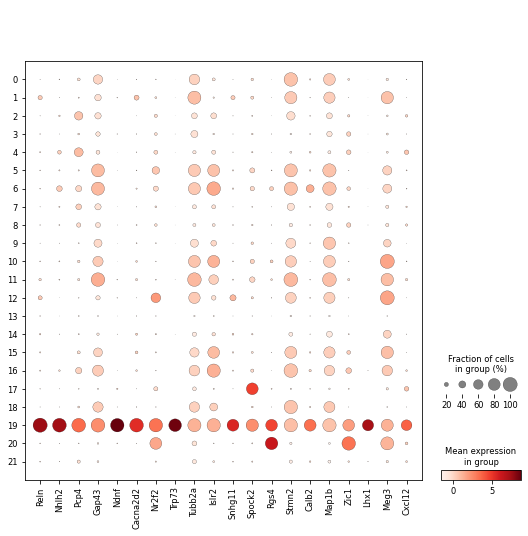

In [175]:
sc.pl.dotplot(adata, groupby = 'leiden', var_names = rankgenenames(adata, 19), save = 'G19')

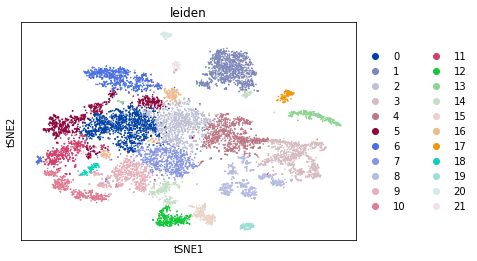

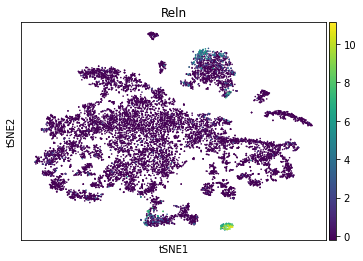

In [176]:
sc.pl.tsne(adata, color = 'leiden')
sc.pl.tsne(adata, color = 'Reln')

In group 20, high expression of Kcnj8, an inward rectifier potassium channel, can be observed, and this indicates that group 20 is contractile cells, likely vascular smooth muscle cells that control blood flow in brains.

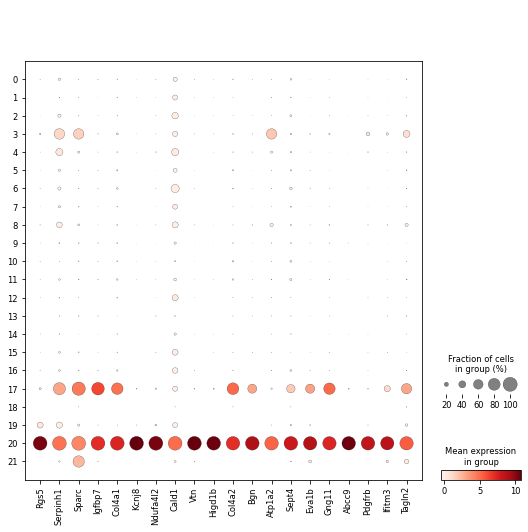

In [177]:
sc.pl.dotplot(adata, groupby = 'leiden', var_names = rankgenenames(adata, 20), save = 'G20')

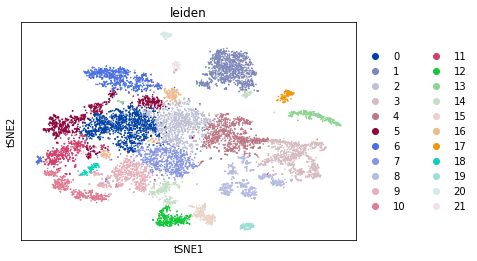

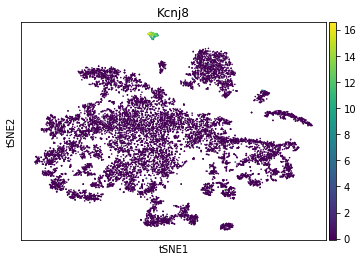

In [178]:
sc.pl.tsne(adata, color = 'leiden')
sc.pl.tsne(adata, color = 'Kcnj8')

Taken these together, I can annotate cell types on the t-sne map:

In [179]:
adata.obs = adata.obs.replace({'1':'Lhx6(+) GABAergic interneurons',
                  '8':'Neural stem cells',
                  '10':'Layer V/VI subcerebral neurons',
                  '12':'Npas1(+) GABAergic interneurons',
                  '13':'Erythroids',
                  '17':'Endothelial cells',
                  '19':'Cajal-Retzius cells',
                  '20':'Smooth muscle cells'})

... storing 'leiden' as categorical


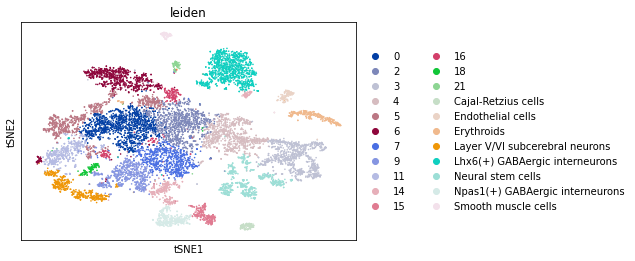

In [180]:
sc.pl.tsne(adata, color = 'leiden', save = 'Annotated')